In [1]:
# The whole point of these functions are to take a DAQ dataset,
# load the quad values from the DAQ into the BMAD model, calculate the R matrices
# then perform a 'fit' to the jitter to derive (x, x', \delta) for each shot.


In [2]:
import scipy
import numpy as np
import matplotlib.pyplot as plt
import physicselog
import h5py
from scipy.optimize import curve_fit
import pandas as pd
import seaborn as sns

# Load the common python classes to handle BMAD and DAQ instances
import sys
sys.path.append('/usr/local/facet/tools/python/F2_pytools/orbit_fitting/')

from BMADMODEL import bmadModel
from DAQDATASET import daqDataSet
from PVDATA import pvData

In [3]:
# The element numbers define the region of the linac of interest.
# They don't really do anything anymore...
bmad = bmadModel(1268, 1595)

In [4]:
# Load a DAQ dataset 
daqNum = 'E320_13195'
daq = daqDataSet('/nas/nas-li20-pm00/E320/2025/20250519/'+daqNum+'/'+daqNum+'.mat')

In [5]:
# Create lists to manually translate between EPICS and BMAD because naming is hard.
li20_quads_epic = [
 'LI20_LGPS_3011_BACT',
 'LI20_LGPS_3311_BACT',
 'LI20_LGPS_3151_BACT',
 'LI20_LGPS_1910_BACT',
 'LI20_LGPS_3204_BACT',
 'LI20_LGPS_3031_BACT',
 'LI20_LGPS_3141_BACT',
 'LI20_LGPS_3261_BACT',
 'LI20_LGPS_3091_BACT'
]

li20_quads_bmad = [
 'Q5FF',
 'Q4FF',
 'Q3FF',
 'Q2FF',
 'Q1FF',
 'Q0FF',
 'Q0D',
 'Q1D',
 'Q2D']

li20_bpms_epic = [
 'BPMS_LI20_2445',
 'BPMS_LI20_3013',
 'BPMS_LI20_3036',
 'BPMS_LI20_3101',
 'BPMS_LI20_3120',
 'BPMS_LI20_3156',
 'BPMS_LI20_3218',
 'BPMS_LI20_3265',
 'BPMS_LI20_3315',
 'BPMS_LI20_3340']

li20_bpms_bmad = [
 'M11E',
 'M1FF',
 'M2FF',
 'M3FF',
 'M4FF',
 'M5FF',
 'M0EX',
 'M1EX',
 'M2EX',
 'M3EX']

In [6]:
# Define a function to do the fit.
def jitterFit(T, B):
    return (np.linalg.pinv(T.T @ T)) @ (T.T @ B)

# Update the magnet values in BMAD to match the EPICS settings

In [7]:

# From the daq data, grab the quad values for all the quads in the bmad model
dqv = daq.returnScalarPVmean(li20_quads_epic)

# Convert the epics values to bmad quad values
dqv = bmad.convertEPICSkGtoBMADTperM(li20_quads_bmad, dqv)

# Grab the design BMAD quad values.
bqvDesign = bmad.returnBmadQuadValues(li20_quads_bmad)

# # set the quads in the bmad model to the values from the daq
bmad.setBmadQuad(li20_quads_bmad, dqv)

# Grab the current BMAD quad values.
bqv = bmad.returnBmadQuadValues(li20_quads_bmad)

# Print everything out so it is easy to interpret
print("{:^20} {:^14} {:20} {:20} {:13}".format("EPICS Quad Name",      "BMAD Quad Name", "Des. B1_GRAD [T/m]", " Cur. B1_GRAD [T/m]", "EPICS [T/m]"), end="\n")
print("{:^20} {:^14} {:20} {:20} {:13}".format("--------------------", "--------------", "------------------","-------------------", "-------------"), end="\n")
for a in zip(li20_quads_epic, li20_quads_bmad, bqvDesign, bqv, dqv):
    print("{:^20} {:^14} {:^ 20.3f} {:^ 20.3f} {:^ 13.3f}".format(a[0], a[1], a[2], a[3], a[4]), end="\n")

  EPICS Quad Name    BMAD Quad Name Des. B1_GRAD [T/m]    Cur. B1_GRAD [T/m]  EPICS [T/m]  
-------------------- -------------- ------------------   -------------------  -------------
LI20_LGPS_3011_BACT       Q5FF             15.586               13.315            13.315   
LI20_LGPS_3311_BACT       Q4FF             11.377               11.611            11.611   
LI20_LGPS_3151_BACT       Q3FF            -13.893              -13.955           -13.955   
LI20_LGPS_1910_BACT       Q2FF            -17.692              -19.516           -19.516   
LI20_LGPS_3204_BACT       Q1FF             32.935               36.100            36.100   
LI20_LGPS_3031_BACT       Q0FF            -17.692              -19.516           -19.516   
LI20_LGPS_3141_BACT       Q0D              10.969                6.385            6.385    
LI20_LGPS_3261_BACT       Q1D             -18.086              -10.148           -10.148   
LI20_LGPS_3091_BACT       Q2D              10.969                6.385          

# Extract the BPM data and do the fit.

In [8]:
# Pick the BPMS to do the reconstruction with.
bmadBPMS = ['M11E', 'M1FF', 'M2FF', 'M4FF']
# bmadBPMS = ['M11E', 'M1FF', 'M2FF', 'M4FF', 'M0EX', 'M1EX', 'M2EX']

# Translate the names from BMAD to epics
epicsBPMS = [li20_bpms_epic[li20_bpms_bmad.index(ele)] for ele in bmadBPMS]

# Build the T matrices
Tx, Ty = bmad.calculateTMatrix(bmadBPMS)

# Build the B matrices
Bx, By = daq.returnBpmXandY(epicsBPMS)

# Convert from mm to m
Bx = Bx*1e-3
By = By*1e-3

# Perform the "fit" for the input beam parameters
QxHat1 = jitterFit(Tx, Bx)
QyHat1 = jitterFit(Ty, By)

# Reformat the data to make it easier to interpret

In [9]:
# Turn the data into a dataframe for ease of plotting.
dfNames = ["X", "Xp", "deltaX", "Y", "Yp", "deltaY"]
temp = np.concatenate( (QxHat1.T, QyHat1.T), axis = 1)
# fart = np.concatenate( (QxHat2.T, QyHat2.T), axis = 1)
df = pd.DataFrame(data = temp)
df.rename(columns={i : dfNames[i] for i in range(6)}, inplace=True)

# Put the columns in the order you'd expect:
df = df[["X", "Xp", "Y", "Yp", "deltaX", "deltaY"]]

# There a few nans in there, get rid of them
df = df.dropna()

# Cut out outliers
df = df[np.abs(scipy.stats.zscore(df['X'])) < 3]
df = df[np.abs(scipy.stats.zscore(df['Xp'])) < 3]
df = df[np.abs(scipy.stats.zscore(df['Y'])) < 3]
df = df[np.abs(scipy.stats.zscore(df['Yp'])) < 3]

# Plot the crrelogram to visualize the data

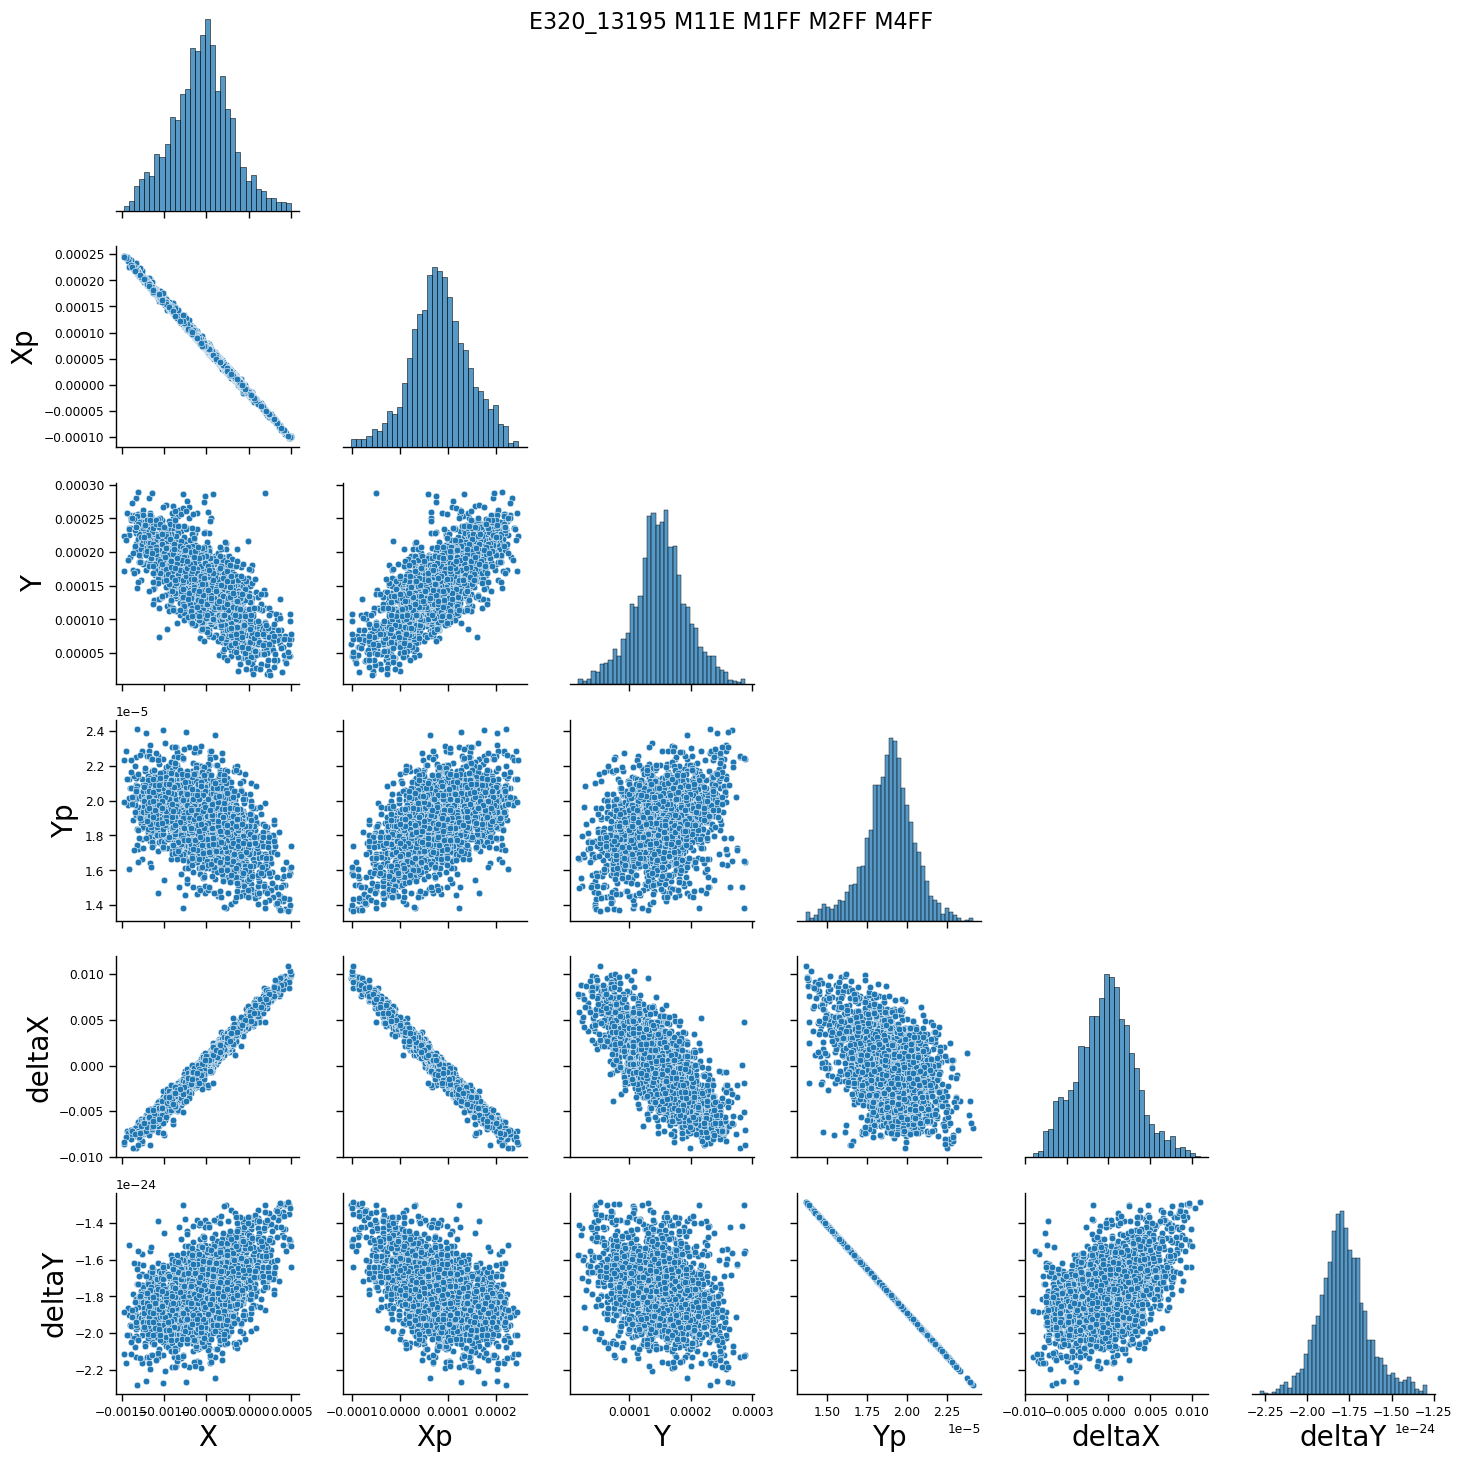

In [10]:
sns.set_context("paper", rc={"font.size":20, "axes.titlesize":20, "axes.labelsize":20})

# Basic correlogram
g = sns.pairplot(df, corner=True)
g.fig.suptitle(daqNum + " " + " ".join(bmadBPMS), fontsize=16)

# g.map_lower(sns.kdeplot, levels=4, color=".2")

plt.show()